In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# read data
df = pd.read_csv("../data/processed_data.csv")
df

,subject,description,integration,objective,quality,refactoring,testing,categoryCount,subjDescription
0,wip better connection test,assign configure fake connections test class d...,0,1,0,0,1,2,wip better connection testassign configure fa...
1,ansible standardcontainer,patchset move role task main yaml file use con...,0,1,1,0,0,2,ansible standardcontainerpatchset move role ...
2,switch testtools remove pep warn unit test dba...,bug blueprint changeid iffcdbcfbeecdeacebdb,1,1,0,0,1,3,switch testtools remove pep warn unit test dba...
3,minor wsgi py,minor code file suggest termie henry review c...,0,1,0,1,0,2,minor wsgi pyminor code file suggest termie ...
4,minor wsgi py,minor wsgi py minor code file suggest termie...,0,1,0,1,0,2,minor wsgi pyminor wsgi py minor code file ...
...,...,...,...,...,...,...,...,...,...
1701,xenapi spawn prep code share,xenapi spawn code share fix bug relate incons...,0,1,1,0,0,2,xenapi spawn prep code sharexenapi spawn cod...
1702,xenapi volumeops attach,attach code readable time check vm run hotplu...,0,1,1,0,0,2,xenapi volumeops attach attach code readable ...
1703,xenapi rawtgzimage common,review request rawtgzimage class move common t...,0,1,1,0,0,2,xenapi rawtgzimage commonreview request rawtg...
1704,xenapi updateglanceimage common,review recommend updateglanceimage common libr...,0,1,0,1,0,2,xenapi updateglanceimage commonreview recomme...


In [3]:
# apply additional preprecessing

# remove changeid which is present in every description by default
df.description = df.description.str.replace("changeid ","")
df.subjDescription = df.subjDescription.str.replace("changeid ","")

In [4]:
# create TF-IDFs for all documents
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.subjDescription).toarray()
labels = df.integration
features.shape

(1706, 1799)

In [5]:
# split train and test set
target_labels = ["integration","objective","quality","refactoring","testing"]
targets = df[target_labels].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1364, 1799), (342, 1799), (1364, 5), (342, 5))

In [6]:
def print_model_results(y_test, y_pred, target_labels,display_categories=False):
    # Evaluate overall performance of the model
    acc = accuracy_score(y_test.ravel(), y_pred.ravel())
    print('Overall accuracy:', acc)
    f1 = f1_score(y_test.ravel(), y_pred.ravel())
    print('Overall f1:', f1)
    print("\n\n")

    print(classification_report(y_test,y_pred, target_names=target_labels))
    
    # Evaluate performance for different categories
    if (display_categories):
        for i in range(len(target_labels)):
            cat_pred = y_pred[:, i]
            cat_test = y_test[:, i]
            disp = ConfusionMatrixDisplay(confusion_matrix(cat_test,cat_pred),)
            disp.plot()
            disp.ax_.set_title(f"Category: {target_labels[i]}")
            plt.show()

            acc = accuracy_score(cat_test, cat_pred)
            print('Category accuracy:', acc)
            f1 = f1_score(cat_test, cat_pred)
            print('Category f1:', f1)
            
        rows = 2
        cols = 3
        fig, axes = plt.subplots(rows, cols, figsize=(15,10))
        for col_i in range(len(target_labels)):
            row_i = col_i//cols
            colname = target_labels[col_i]
            cat_pred = y_pred[:, col_i]
            cat_test = y_test[:, col_i]
            disp = ConfusionMatrixDisplay(confusion_matrix(cat_test,cat_pred),)
            disp.plot(ax=axes[row_i, col_i%cols])
            axes[row_i, col_i%cols].set_title(f"Category: {target_labels[col_i]}")

        axes[1,2].axis('off')
        fig.tight_layout()  
        fig.subplots_adjust(hspace=0.5) 
        plt.show()
        fig.savefig('output/confusion_matrices_tfidf.jpg')            
        print("\n\n")
        
    print("\n\n")

In [7]:
# instantiate selected classifiers
models = [MultinomialNB(), RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42), KNeighborsClassifier(), RidgeClassifier(random_state=42), RidgeClassifierCV()]

# iterate over each classifier - train it and print results
for model in models:
    print("Model:", model)
    
    # Train the model
    multi_target_model = MultiOutputClassifier(model, n_jobs=2, )
    multi_target_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = multi_target_model.predict(X_test)

    print_model_results(y_test, y_pred, target_labels, display_categories=False)
    print

Model: MultinomialNB()
Overall accuracy: 0.8175438596491228
Overall f1: 0.7833333333333333



              precision    recall  f1-score   support

 integration       0.95      0.22      0.36        85
   objective       0.81      1.00      0.89       272
     quality       0.65      0.84      0.73       177
 refactoring       1.00      0.09      0.17        32
     testing       0.89      0.82      0.85       150

   micro avg       0.78      0.79      0.78       716
   macro avg       0.86      0.59      0.60       716
weighted avg       0.81      0.79      0.75       716
 samples avg       0.78      0.77      0.75       716




Model: RandomForestClassifier(random_state=42)
Overall accuracy: 0.87953216374269
Overall f1: 0.8581267217630852



              precision    recall  f1-score   support

 integration       0.94      0.72      0.81        85
   objective       0.85      0.97      0.91       272
     quality       0.76      0.85      0.80       177
 refactoring       0.75    

C:\Users\tschw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall accuracy: 0.8011695906432749
Overall f1: 0.7645429362880886



              precision    recall  f1-score   support

 integration       0.66      0.68      0.67        85
   objective       0.85      0.85      0.85       272
     quality       0.68      0.70      0.69       177
 refactoring       0.19      0.19      0.19        32
     testing       0.86      0.88      0.87       150

   micro avg       0.76      0.77      0.76       716
   macro avg       0.65      0.66      0.65       716
weighted avg       0.76      0.77      0.76       716
 samples avg       0.74      0.75      0.72       716




Model: KNeighborsClassifier()


C:\Users\tschw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall accuracy: 0.7748538011695907
Overall f1: 0.717948717948718



              precision    recall  f1-score   support

 integration       0.63      0.42      0.51        85
   objective       0.83      0.83      0.83       272
     quality       0.68      0.60      0.63       177
 refactoring       0.26      0.16      0.20        32
     testing       0.81      0.79      0.80       150

   micro avg       0.76      0.68      0.72       716
   macro avg       0.64      0.56      0.59       716
weighted avg       0.74      0.68      0.71       716
 samples avg       0.71      0.67      0.66       716




Model: RidgeClassifier(random_state=42)


C:\Users\tschw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall accuracy: 0.8461988304093567
Overall f1: 0.8177408177408177



              precision    recall  f1-score   support

 integration       0.87      0.65      0.74        85
   objective       0.83      0.95      0.89       272
     quality       0.70      0.79      0.74       177
 refactoring       0.83      0.16      0.26        32
     testing       0.90      0.88      0.89       150

   micro avg       0.81      0.82      0.82       716
   macro avg       0.83      0.68      0.70       716
weighted avg       0.82      0.82      0.81       716
 samples avg       0.79      0.80      0.77       716




Model: RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))


C:\Users\tschw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall accuracy: 0.8473684210526315
Overall f1: 0.8220858895705521



              precision    recall  f1-score   support

 integration       0.87      0.65      0.74        85
   objective       0.81      1.00      0.89       272
     quality       0.70      0.79      0.74       177
 refactoring       0.83      0.16      0.26        32
     testing       0.90      0.88      0.89       150

   micro avg       0.80      0.84      0.82       716
   macro avg       0.82      0.69      0.71       716
weighted avg       0.81      0.84      0.81       716
 samples avg       0.79      0.83      0.79       716






Overall accuracy: 0.87953216374269
Overall f1: 0.8581267217630852



              precision    recall  f1-score   support

 integration       0.94      0.72      0.81        85
   objective       0.85      0.97      0.91       272
     quality       0.76      0.85      0.80       177
 refactoring       0.75      0.09      0.17        32
     testing       0.91      0.96      0.94       150

   micro avg       0.85      0.87      0.86       716
   macro avg       0.84      0.72      0.72       716
weighted avg       0.85      0.87      0.84       716
 samples avg       0.82      0.85      0.82       716



C:\Users\tschw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


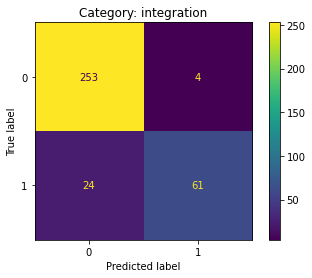

Category accuracy: 0.9181286549707602
Category f1: 0.8133333333333334


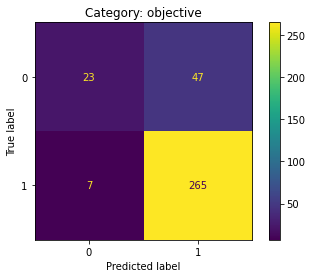

Category accuracy: 0.8421052631578947
Category f1: 0.9075342465753424


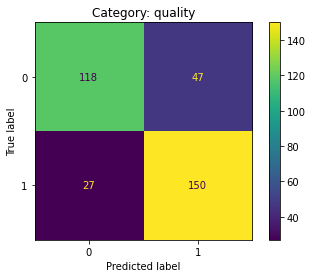

Category accuracy: 0.783625730994152
Category f1: 0.8021390374331551


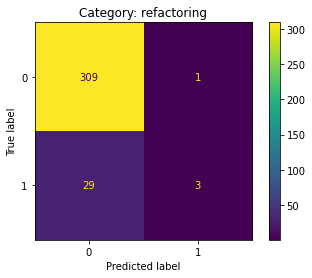

Category accuracy: 0.9122807017543859
Category f1: 0.16666666666666666


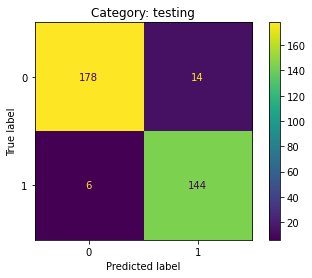

Category accuracy: 0.9415204678362573
Category f1: 0.935064935064935


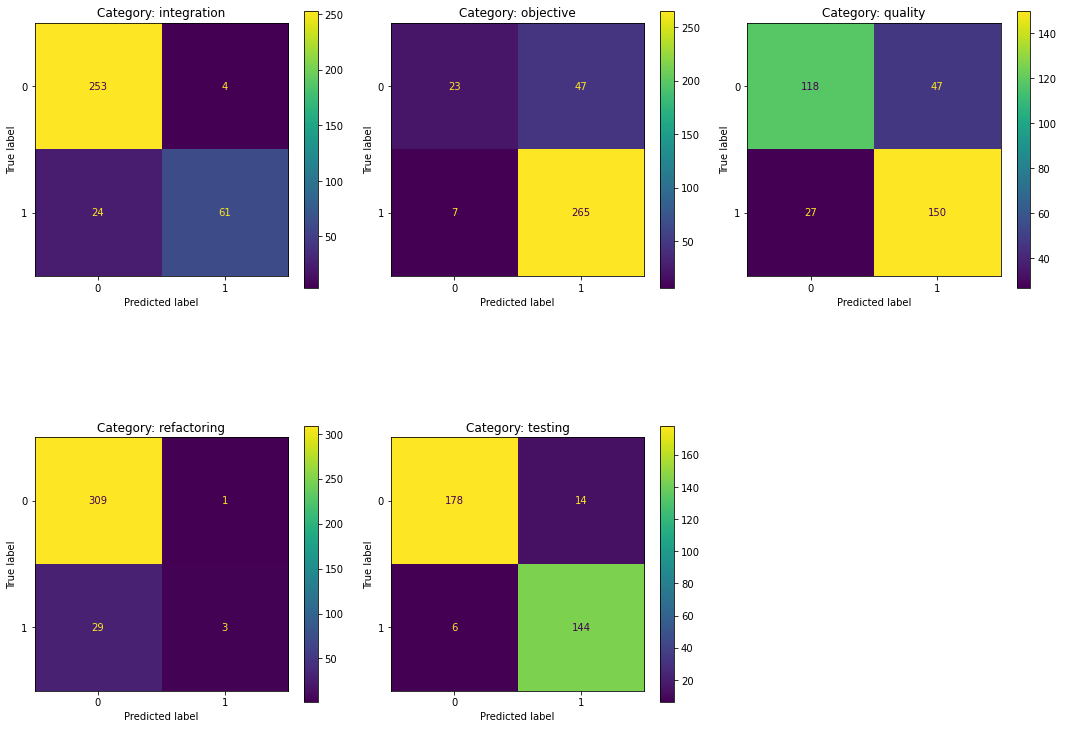

In [8]:
# Focus on best performing model: Random Forest

# Train the model
model = RandomForestClassifier(random_state=42)
multi_target_model = MultiOutputClassifier(model, n_jobs=2)

multi_target_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_target_model.predict(X_test)

# print results including breakdown to different categories
print_model_results(y_test, y_pred, target_labels, display_categories=True)

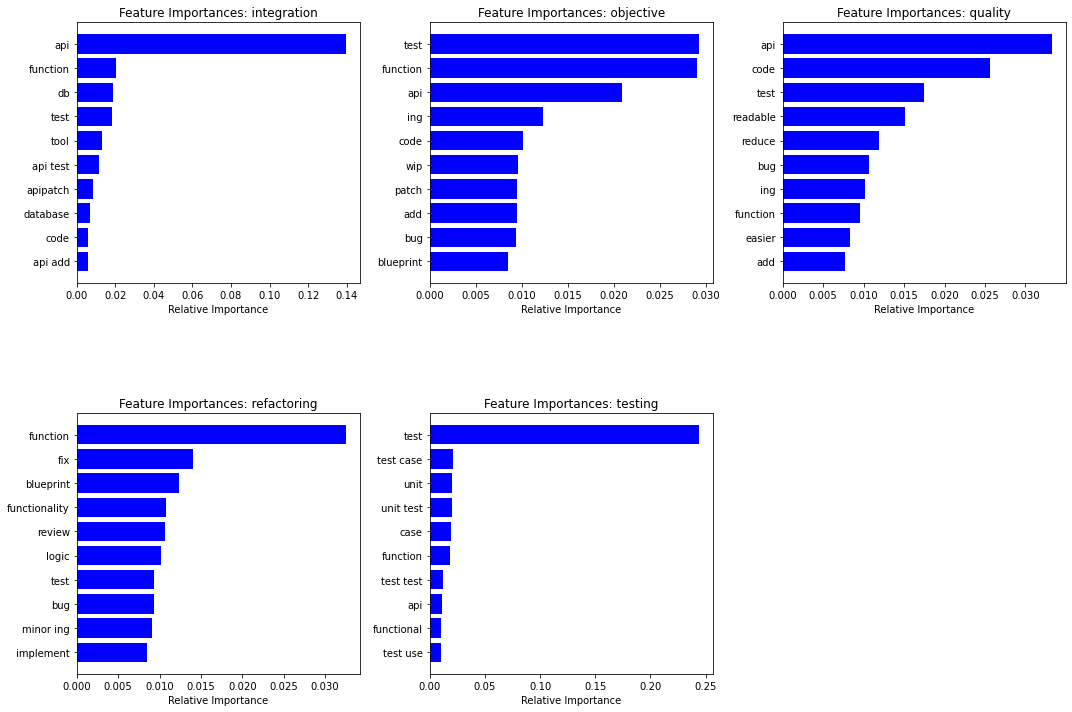

In [9]:
# Determine feature importance (for Random Forest model)
feature_names = tfidf.get_feature_names_out()
limit = 10

rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15,10))
for i in range(len(multi_target_model.estimators_)):
    row_i = i//cols
    estimator = multi_target_model.estimators_[i]
    feat_importances = pd.Series(estimator.feature_importances_, index=feature_names).sort_values(ascending=False)[:limit][::-1]

    ax = axes[row_i, i%cols]
    ax.barh(range(len(feat_importances)), feat_importances, color='b', align='center')
    ax.set_yticks(range(len(feat_importances)), feat_importances.index)
    ax.set_xlabel('Relative Importance')
    ax.set_title(f'Feature Importances: {target_labels[i]}')


axes[1,2].axis('off')
fig.tight_layout()  
fig.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig('output/feature_importance_tfidf.jpg')       